# This is the new portion of the code that has been inspired by the origin code given


In [6]:
using Plots, Ipopt, JuMP, QuadGK, DifferentialEquations


#JuMP model, Ipopt solver

sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-8)
set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
set_optimizer_attribute(sys,"max_iter",1000)



# Parameters

# Coefficients du modèlprintln("Valeurs optimales de s(T) : ", [value(s[T])] )
# println("Valeurs optimales de i(T) : ", [value(i[T])] )
# println("Valeurs optimales de m(T) : ", [value(m[T])] )
const A = 10.0
const B = 1.0
const C = 3.0
const T = 20

# Valeurs initiales
const s0 = 0.95
const i0 = 0.05
const m0 = 0.0
#const t0 = 0.0

x0 = [ s0, i0, m0 ]

# Autres paramètres
const N = 200                   # la valeur N=200 nous donne j1=26.23 
const ε = 1e-9
const dt = T/N

# Valeurs des paramètres SIMR
const b = 0.01
const c = 1.1
const a1 = 0.08
const a2 = 0.005
const g1 = 0.02
const g2 = 0.5
const η = 0.8

# Valeurs maximales des contrôles
const umax = 0.8
const vmax = 0.8


# Variables d'état s(t), i(t), et m(t) et de control u(t) et v(t)

@variables(sys, begin
    0.0 <= Δt                      # time step
    0 <= s[1:N+1]                  # s state (voire s[t=0:N] >= 0 je ne sais pas ce que ça change)
    0 <= i[1:N+1]                  # i state (i[t=0:N] >= 0)
    0 <= m[1:N+1]                  # m state (m[t=0:N] >= 0)
    0 <= u[1:N+1] <= umax         # u control
    0 <= v[1:N+1] <= vmax         # v control
end)




# Expression pour J1(u, v)

@expression(sys, J1, 0.5 * Δt * sum((A * i[t] + B * u[t] + C * v[t] + A * i[t+1] + B * u[t+1] + C * v[t+1]) for t in 1:N))
# Objective
@objective(sys, Min, J1)


# Boundary constraints 

@constraints(sys, begin
    con_s0, s[1] == s0
    con_i0, i[1] == i0
    con_m0, m[1] == m0
    con_iT, i[T] <= 5e-4
end)


# Dynamics
@NLexpressions(sys, begin
    # s' = b - b.s - c.s.i + (a1.i + a2.m).s - η.u.s
    ds[j = 1 : N + 1], ( b - b * s[j] - c * s[j] * i[j] + ( a1 * i[j] + a2 * m[j] ) * s[j] - η * u[j] * s[j] )
    # i' = c.s.i - b.i - (g1 + a1).i + (a1.i + a2.m).i - i.v
    di[j = 1 : N + 1], ( c * s[j] * i[j] - b * i[j] - ( g1 + a1 ) * i[j] + ( a1 * i[j] + a2 *m[j] ) * i[j] - i[j] * v[j])
    # m' = -(a2 + g2 + b).m + (a1.i + a2.m).m + i.v
    dm[j = 1 : N + 1], ( - ( a2 + g2 + b ) * m[j] + ( a1 * i[j] + a2 * m[j] ) * m[j] + i[j] * v[j] )
end)

# Crank-Nicolson scheme
@NLconstraints(sys, begin
    con_ds[j = 1:N ], s[j+1] == s[j] + Δt * (ds[j] + ds[j+1])/2.0
    con_di[j = 1:N ], i[j+1] == i[j] + Δt * (di[j] + di[j+1])/2.0
    con_dm[j = 1:N ], m[j+1] == m[j] + Δt * (dm[j] + dm[j+1])/2.0
end)

(NonlinearConstraintRef{ScalarShape}[(s[2] - (s[1] + (Δt * (subexpression[1] + subexpression[2])) / 2.0)) - 0.0 = 0, (s[3] - (s[2] + (Δt * (subexpression[2] + subexpression[3])) / 2.0)) - 0.0 = 0, (s[4] - (s[3] + (Δt * (subexpression[3] + subexpression[4])) / 2.0)) - 0.0 = 0, (s[5] - (s[4] + (Δt * (subexpression[4] + subexpression[5])) / 2.0)) - 0.0 = 0, (s[6] - (s[5] + (Δt * (subexpression[5] + subexpression[6])) / 2.0)) - 0.0 = 0, (s[7] - (s[6] + (Δt * (subexpression[6] + subexpression[7])) / 2.0)) - 0.0 = 0, (s[8] - (s[7] + (Δt * (subexpression[7] + subexpression[8])) / 2.0)) - 0.0 = 0, (s[9] - (s[8] + (Δt * (subexpression[8] + subexpression[9])) / 2.0)) - 0.0 = 0, (s[10] - (s[9] + (Δt * (subexpression[9] + subexpression[10])) / 2.0)) - 0.0 = 0, (s[11] - (s[10] + (Δt * (subexpression[10] + subexpression[11])) / 2.0)) - 0.0 = 0  …  (s[192] - (s[191] + (Δt * (subexpression[191] + subexpression[192])) / 2.0)) - 0.0 = 0, (s[193] - (s[192] + (Δt * (subexpression[192] + subexpression[193]

In [7]:
# Solves for the control and state
println("Solving...")
status = optimize!(sys)

if termination_status(sys) == MOI.OPTIMAL
    println("Solution is optimal")

elseif termination_status(sys) == MOI.LOCALLY_SOLVED
    println("Local solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("The model was not solved correctly.")
end
println("Objective value = ", objective_value(sys), "\n")

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
ss = value.(s)
ii = value.(i)
mm = value.(m)
uu = value.(u)
vv = value.(v)
Δtt = value.(Δt)
println("Δt = ", Δtt)
p_s = -[ dual(con_ds[j]) for j = 1:N - 1]
p_i = -[ dual(con_di[j]) for j = 1:N - 1]
p_m = -[ dual(con_dm[j]) for j = 1:N - 1];

Solving...



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:     5003
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:    24203

Total number of variables............................:     1006
                     variables with only lower bounds:      604
                variables with lower and upper bounds:      402
                     variables with only upper bounds:        0
Total number of equality constraints.................:      603
Total number of inequality c

Objective value = 26.234092980320323

Δt = 0.3695981549798539


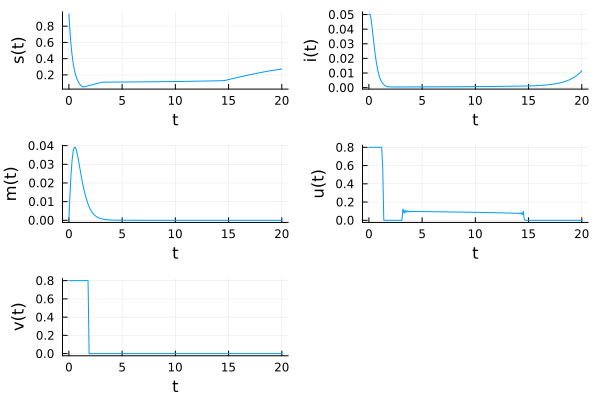

In [8]:
# Plots: state and control
t = (0:N)*dt
s_plot = plot(t, ss, xlabel = "t", ylabel = "s(t)", legend = false, fmt = :png)
i_plot = plot(t, ii, xlabel = "t", ylabel = "i(t)", legend = false, fmt = :png)
m_plot = plot(t, mm, xlabel = "t", ylabel = "m(t)", legend = false, fmt = :png)
u_plot = plot(t, uu, xlabel = "t", ylabel = "u(t)", legend = false, fmt = :png)
v_plot = plot(t, vv, xlabel = "t", ylabel = "v(t)", legend = false, fmt = :png)

display(plot(s_plot, i_plot, m_plot, u_plot, v_plot, layout = (3,2)))

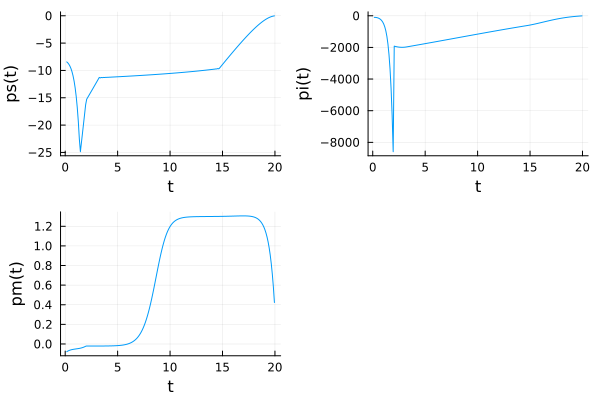

In [9]:
# Plots: adjoint state
tt = (t[2:end-1] + t[3:end])/2.0
p_s_plot = plot(tt, p_s, xlabel = "t", ylabel = "ps(t)", legend = false, fmt = :png)
p_i_plot = plot(tt, p_i, xlabel = "t", ylabel = "pi(t)", legend = false, fmt = :png)
p_m_plot = plot(tt, p_m, xlabel = "t", ylabel = "pm(t)", legend = false, fmt = :png)
# calculer la taille de pi
display(plot(p_s_plot, p_i_plot, p_m_plot, layout = (2,2)))

# Calcul des fonctions de switch

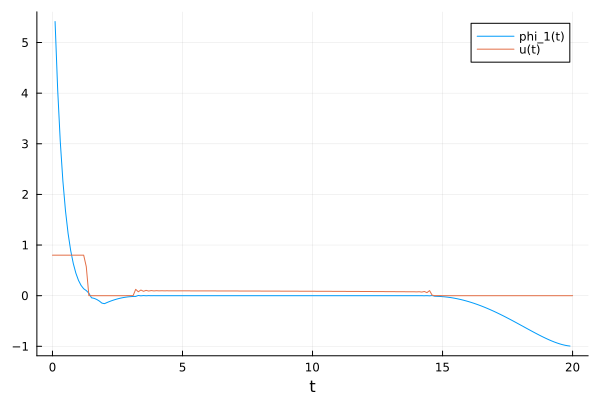

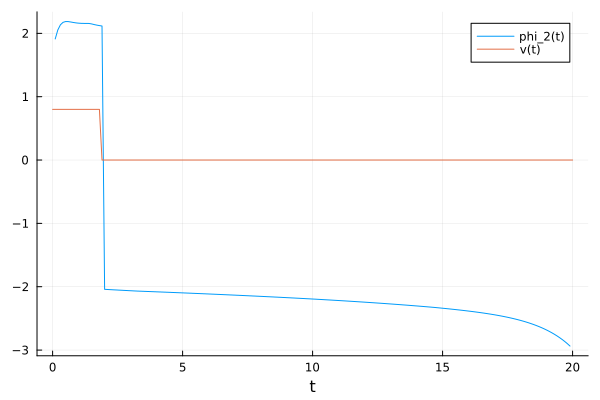

phi_11 = [5.414538158349767, 4.068422615688927, 3.0442788882543352, 2.2670771578588025, 1.6777005270839198, 1.2306980194552448, 0.8918578423176187, 0.6358107292486437, 0.4439390864626609, 0.30271312892769475, 0.20244776898396322, 0.1364155071425477, 0.10023934666627854, 0.048797359158521125, -0.04164694349237641, -0.05300553745860648, -0.0743114854304252, -0.10559864975308897, -0.14689205143407003, -0.1577451928494511, -0.13497525661916532, -0.1141965239964029, -0.09540363593741263, -0.07859130121186197, -0.06375427962719737, -0.05088736514100867, -0.03998536928409002, -0.031043104043146585, -0.02405536137469466, -0.019016874876591983, -0.01592212828418549, -0.014757322973425024, 0.003663728723298121, -0.003415894373667072, 0.0017143782405109054, -0.0019814092123032756, 0.0006933781450471077, -0.001239922017486239, 0.0001537355137455343, -0.0008551701444230453, -0.000132116059861076, -0.0006570117612872961, -0.0002841880484165671, -0.000556679593389342, -0.00036606498711455604, -0.0005

In [85]:

function phi_1(t)
    return (-η * p_s[t] * ss[t] - B )
end

function phi_2(t)
    return ((p_m[t]- p_i[t]) * ii[t] - C)
end

phi_11 = [phi_1(j) for j in 1:N-1]
phi_22 = [phi_2(j) for j in 1:N-1]
#println("phi_11 = ", phi_11)

tt = (1:N-1)*dt
t = (0:N)*dt

phi_1_plot = plot(tt, phi_11, xlabel = "t", label = "phi_1(t)" , fmt = :png)
plot!( t, uu, label = "u(t)")

phi_2_plot = plot(tt, phi_22, xlabel = "t", label = "phi_2(t)" , fmt = :png)
plot!( t, vv, label = "v(t)")

display(plot(phi_1_plot))  
display(plot(phi_2_plot))

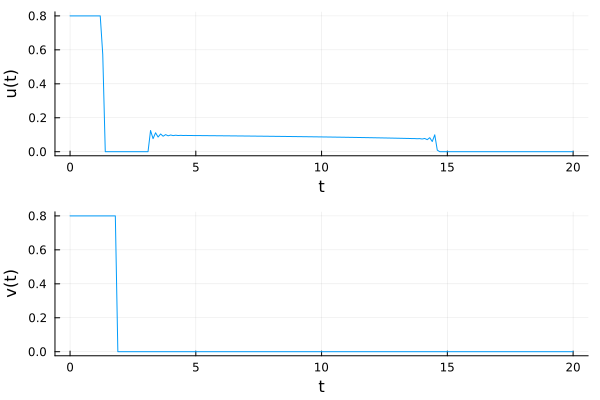

In [48]:
display(plot(u_plot, v_plot, layout = (2,1)))

In [92]:
# Afficher les résultats
println("Valeur optimale de J1(u, v) : ", objective_value(sys))
println("Valeur optimale de s(T) : ", [value(s[T])] )
println("Valeur optimale de i(T) : ", [value(i[T])] )
println("Valeur optimale de m(T) : ", [value(m[T])] )

println("Valeur optimale de ps(0) : ", [value(p_s[1])] )
println("Valeur optimale de pi(0) : ", [value(p_i[1])] )
println("Valeur optimale de pm(0) : ", [value(p_m[1])] )
println("Valeur optimale de ps(T) : ", [value(p_s[T])] )
println("Valeur optimale de pi(T) : ", [value(p_i[T])] )
println("Valeur optimale de pm(T) : ", [value(p_m[T])] )


Valeur optimale de J1(u, v) : 26.234092980320323
Valeur optimale de s(T) : [0.06895965620929256]
Valeur optimale de i(T) : [0.000500009999628082]
Valeur optimale de m(T) : [0.0073011918060191545]
Valeur optimale de ps(0) : [-8.440181787302325]
Valeur optimale de pi(0) : [-98.3112889964161]
Valeur optimale de pm(0) : [-0.07884949712368798]
Valeur optimale de ps(T) : [-15.267165859163825]
Valeur optimale de pi(T) : [-1917.9564265991894]
Valeur optimale de pm(T) : [-0.020515047766905926]


## Shooting method


In [102]:
#include("flow.jl")

t0=0.0

# Dynamics
function F0(x)
    s, i, m = x
    F = [ b - b*s - c*s*i + ( a1*i + a2*m )*s  , c*s*i - b*i - (g1+a1)*i + (a1*i + a2*m)*i , -(a2+g2+b)*m + (a1*i + a2*m)*m ]
    return F
end

function F1(x)
    s, i, m = x
    F = [ - η*u*s, 0.0, 0.0 ]
    return F
end

function F2(x)
    s, i, m = x
    F = [ 0.0 ,- i, i ]
    return F
end

#Les crochets de Lie
#function Poisson(f,g)
#    return (x) -> f(x)'*g(x) - g(x)'*f(x)
#end    

# Computation of singular control of order 1
H0 = (x, p) -> p' * F0(x)
H1 = (x, p) -> p' * F1(x)
H2 = (x, p) -> p' * F2(x)
H01 = Poisson(H0, H1)
H001 = Poisson(H0, H01)
H101 = Poisson(H1, H01)
us = (x, p) -> -H001(x, p)/H101(x, p)

# Hamiltonians (regular, singular) and associated flows
H = (x, p, u) -> H0(x, p) + u*H1(x, p)
Hr = (x, p) -> H(x, p, 1.0)
Hs = (x, p) -> H(x, p, us(x, p))


# Def de Flow
# struct Flow{T}
#     equation::T
# end

#function (f::Flow)(x₀, t_span)
    #t, x = t_span[1], x₀
    #h = 0.1  #t_span[2] - t_span[1]      #on peut prendre la valeur 0.01 par ex

    #while t < t_span[2]
       # x += h * f.equation(x,t)
       # t += h
    #end

#    return x
#end
# Ajoute une méthode pour accepter les types d'arguments attendus
#function (f::Flow)(x₀::Vector{Float64}, t_span::Tuple{Float64, Float64})
#    return f(x₀, t_span)
#end


# function (f::Flow)(x₀, t_span)
#     ode = ODEProblem(f.equation, x₀, t_span)
#     sol = solve(ode, Tsit5(), dt=0.01)  # Choisis la méthode d'intégration adaptative Tsit5

#     return sol.u[end]
# end

#function Flow(H)
#    return (x, p, u) -> H(x, p, u)
#end

#function (f::Flow)(x₀, t_span)
#    t0, tf = t_span
#    h = 0.1  # Choisis une valeur appropriée pour le pas de temps
#    steps = Int((tf - t0) / h)
#    x = x₀
#    for i in 1:steps
#        x += h * f.equation(x, t0 + i * h)
#    end

#    return x
#end


# Flows

f0 = Flow(H0)
fr = Flow(Hr)
fs = Flow(Hs);

In [103]:
# Shooting function
#function shoot(p0, t1, t2, tf) # B+ S B0 structure

#    x1, p1 = fr(t0, x0, p0, t1)
#    x2, p2 = fs(t1, x1, p1, t2)
#    xf, pf = f0(t2, x2, p2, tf)
#    s = zeros(eltype(p0), 6)
#    s[1:2] = pf[1:2] - [ 1.0, 0.0 ]             #les contraintes 
#    s[3] = xf[3] - mf # supposed to be active
#    s[4] = H1(x1, p1)
#    s[5] = H01(x1, p1)
#    s[6] = H0(xf, pf) # free tf

#    return s

#end


function shoot(p0, t1, t2, tf)
    x1 = fr(p0, (0.0, t1))
    x2 = fs(x1, (t1, t2))
    xf = f0(x2, (t2, tf))
    s = zeros(eltype(p0), 6)
    s[1:2] = xf[1:2] - [1.0, 0.0]  # Les contraintes
    s[3] = xf[3] - mf  # Supposed to be active
    s[4] = H1(x1, p0)
    s[5] = H01(x1, p0)
    s[6] = H0(xf, p0)  # Free tf
    return s
end

shoot (generic function with 1 method)

In [104]:
# Initialisations
p0 = [ p_s[1], p_i[1], p_m[1] ] # rough init from direct solve
t1 = 1.75
t2 = 3.0
tf = 15.2
ξ = [ p0 ; t1 ; t2 ; tf ]
# Solve 
foo   = ξ -> shoot(ξ[1:3], ξ[4], ξ[5], ξ[6])
jfoo  = ξ -> ForwardDiff.jacobian(foo, ξ)
foo!  = (s, ξ) -> ( s[:] = foo(ξ); nothing )
jfoo! = (js, ξ) -> ( js[:] = jfoo(ξ); nothing )


println("Initial value of shooting:\n", foo(ξ), "\n\n")

#nl_sol = fsolve(foo!, jfoo!, ξ, show_trace=true); println(nl_sol)
nl_sol = fsolve(foo!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:3]
    t1 = nl_sol.x[4]
    t2 = nl_sol.x[5]
    tf = nl_sol.x[6];
else
    error("Not converged")
end

LoadError: MethodError: no method matching (::var"#739#740"{var"#735#736"})(::Vector{Float64}, ::Tuple{Float64, Float64})

[0mClosest candidates are:
[0m  (::var"#739#740")(::Any, ::Any, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[102]:67[24m[39m
